In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import holidays
from statsmodels.tsa.seasonal import STL

# Создание примерного набора данных (как в предыдущем сообщении)
dates = pd.date_range(start='2023-01-01', periods=180)
np.random.seed(0)
base_data = np.random.normal(loc=100, scale=20, size=len(dates))



# Имитация роста в начале месяца и спада
for i in range(len(dates)):
    if dates[i].day <= 10:
        base_data[i] *= 1.5  # Рост в начале месяца
    elif dates[i].day >= 25:
        base_data[i] *= 0.75  # Спад в конце месяца

# Уменьшение количества заявок в выходные
for i in range(len(dates)):
    if dates[i].weekday() >= 5:
        base_data[i] *= 0.5  # Уменьшение в выходные


# Определение праздничных дней
ru_holidays = holidays.RU(years=[2023, 2024])
holiday_dates = [date for date in dates if date in ru_holidays]

# Уменьшение количества заявок в праздники
for date in holiday_dates:
    base_data[dates.get_loc(date)] *= 0.5  # Уменьшение в праздники

# Создание DataFrame
df = pd.DataFrame({'dt': dates, 'input_': base_data})

df['stage'] = ['Возврат выплат']*len(df)

# Добавление признаков выходных и праздников
us_holidays = holidays.RU()
df['is_weekend'] = (df['dt'].dt.weekday >= 5).astype(int)
df['dow'] = df['dt'].dt.weekday
df['dom'] = df['dt'].dt.day
df['is_holiday'] = df['dt'].apply(lambda x: x in us_holidays).astype(int)
df['month'] = df['dt'].dt.month

df['log_input_'] = np.log(df['input_'])

stl = STL(df['log_input_'], period=7)
res = stl.fit()
df['seasonly'] = res.seasonal
stl = STL(df['log_input_'], period=30)
res = stl.fit()
df['seasonly1'] = res.seasonal
df.set_index('dt', inplace=True)
df

,input_,stage,is_weekend,dow,dom,is_holiday,month,log_input_,seasonly,seasonly1
dt,,,,,,,,,,
2023-01-01,50.730393,Возврат выплат,1,6,1,1,1,3.926525,-0.529902,-0.204952
2023-01-02,81.002358,Возврат выплат,0,0,2,1,1,4.394478,0.266995,0.354295
2023-01-03,89.681070,Возврат выплат,0,1,3,1,1,4.496260,0.416433,0.187179
2023-01-04,108.613398,Возврат выплат,0,2,4,1,1,4.687795,0.223269,0.154847
2023-01-05,103.013370,Возврат выплат,0,3,5,1,1,4.634859,0.334628,0.135869
...,...,...,...,...,...,...,...,...,...,...
2023-06-25,42.611959,Возврат выплат,1,6,25,0,6,3.752135,-0.333463,-0.444938
2023-06-26,62.948855,Возврат выплат,0,0,26,0,6,4.142323,0.064578,-0.568040
2023-06-27,64.656753,Возврат выплат,0,1,27,0,6,4.169093,0.225129,-0.428384


In [ ]:
def MAPE(test, predict):
  MAPE = np.mean(abs(test-predict)/test)*100
  return MAPE

Category: Возврат выплат


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA MAPE: 14.340784240028704


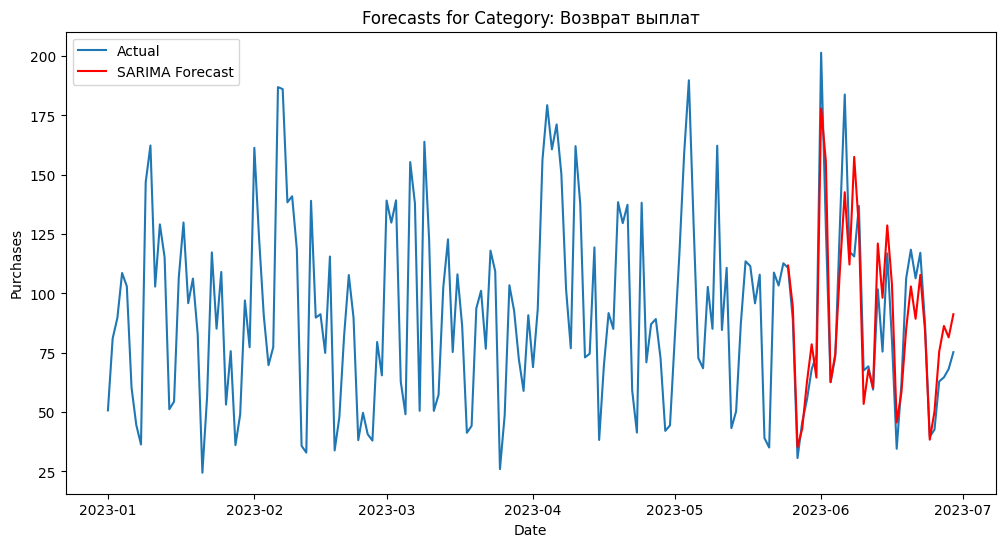

In [ ]:
df['stage'] = ['Возврат выплат']*len(df)
df['dt'] = df.index

# Добавление признаков выходных и праздников
us_holidays = holidays.RU()
df['is_weekend'] = (df['dt'].dt.weekday >= 5).astype(int)
df['dow'] = df['dt'].dt.weekday
df['dom'] = df['dt'].dt.day
df['is_holiday'] = df['dt'].apply(lambda x: x in us_holidays).astype(int)
df['month'] = df.index.month

df['log_input_'] = np.log(df['input_'])

stl = STL(df['log_input_'], period=7)
res = stl.fit()
df['seasonly'] = res.seasonal
stl = STL(df['log_input_'], period=30)
res = stl.fit()
df['seasonly1'] = res.seasonal
# Разделение данных по категориям
categories = df['stage'].unique()

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Модель SARIMA
def fit_sarima_model(data):

    model = auto_arima(data['log_input_'],
                       seasonal=True, m=7,
                       trace=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       maxiter=1000, disp=False)

    order = model.order
    seasonal_order = model.seasonal_order

    model = SARIMAX(data['log_input_'],
                    order=order,
                    seasonal_order=seasonal_order,
                    # exog=data[['dow', 'dom', 'is_weekend', 'is_holiday']])
                    exog=data[['dow', 'dom', 'is_holiday', 'seasonly', 'seasonly1']])
    model_fit = model.fit(disp=False, maxiter=1000)
    return model_fit


# Обработка данных по каждой категории и создание ансамбля моделей
SEQ_LENGTH = 14  # длина последовательности, например, на 7 дней назад

for category in categories:
    print(f'Category: {category}')

    # Фильтрация данных по текущей категории
    # category_data = df[df['stage'] == category][['input_', 'is_weekend', 'is_holiday', 'log_input_', 'dow', 'dom']]
    category_data = df[df['stage'] == category][['input_', 'is_holiday', 'log_input_', 'dow', 'dom', 'seasonly', 'seasonly1']]

    # Разделение на обучающую и тестовую выборки
    train_size = int(len(category_data) * 0.8)
    train_data = category_data.iloc[:train_size]
    test_data = category_data.iloc[train_size:]

    # Обучение SARIMA модели
    sarima_model = fit_sarima_model(train_data)

    # Прогноз SARIMA
    # sarima_forecast = sarima_model.get_forecast(steps=len(test_data),
    #                                             exog=test_data[['dow', 'dom', 'is_weekend', 'is_holiday']])
    sarima_forecast = sarima_model.get_forecast(steps=len(test_data),
                                                exog=test_data[['dow', 'dom', 'is_holiday', 'seasonly', 'seasonly1']])
    sarima_mean_1 = sarima_forecast.predicted_mean

    # Оценка точности
    mse_sarima = MAPE(test_data['input_'], np.exp(sarima_mean))

    print(f'SARIMA MAPE: {mse_sarima}')


    # Визуализация результатов
    plt.figure(figsize=(12, 6))
    plt.plot(category_data['input_'], label='Actual')
    plt.plot(np.exp(sarima_mean), label='SARIMA Forecast', color='r')

    plt.xlabel('Date')
    plt.ylabel('Purchases')
    plt.title(f'Forecasts for Category: {category}')
    plt.legend()
    plt.show()

Category: Возврат выплат


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA MAPE: 14.340784240028704


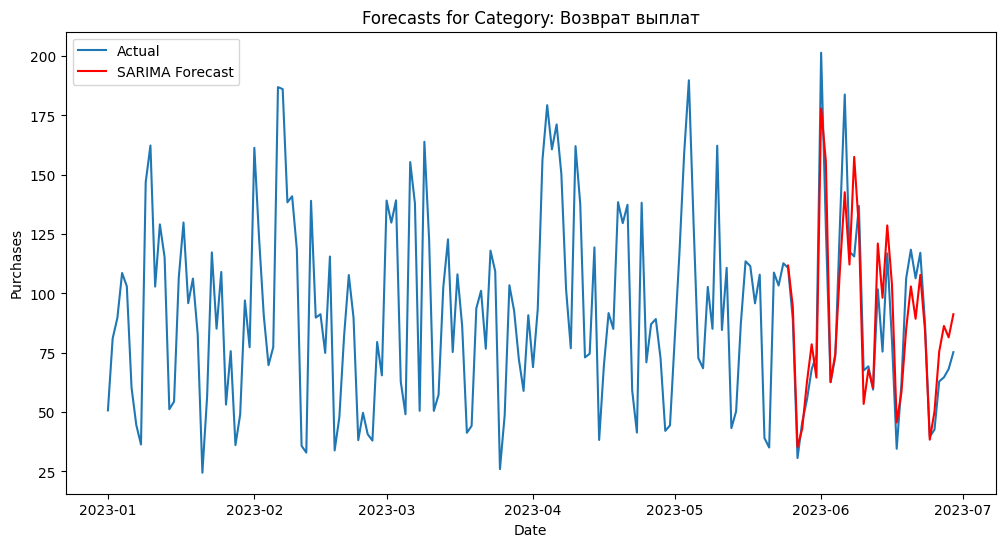

In [ ]:
df['stage'] = ['Возврат выплат']*len(df)

df['dt'] = df.index

# Добавление признаков выходных и праздников
us_holidays = holidays.RU()
df['is_weekend'] = (df['dt'].dt.weekday >= 5).astype(int)
df['dow'] = df['dt'].dt.weekday
df['dom'] = df['dt'].dt.day
df['is_holiday'] = df['dt'].apply(lambda x: x in us_holidays).astype(int)
df['month'] = df.index.month

df['log_input_'] = np.log(df['input_'])

stl = STL(df['log_input_'], period=7)
res = stl.fit()
df['seasonly'] = res.seasonal
stl = STL(df['log_input_'], period=30)
res = stl.fit()
df['seasonly1'] = res.seasonal
# Разделение данных по категориям
categories = df['stage'].unique()

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Модель SARIMA
def fit_sarima_model(data):

    model = auto_arima(data['log_input_'],
                       seasonal=True, m=7,
                       trace=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       maxiter=1000, disp=False)

    order = model.order
    seasonal_order = model.seasonal_order

    model = SARIMAX(data['log_input_'],
                    order=order,
                    seasonal_order=seasonal_order,
                    # exog=data[['dow', 'dom', 'is_weekend', 'is_holiday']])
                    exog=data[['dow', 'dom', 'is_holiday', 'seasonly']])
    model_fit = model.fit(disp=False, maxiter=1000)
    return model_fit


# Обработка данных по каждой категории и создание ансамбля моделей
SEQ_LENGTH = 14  # длина последовательности, например, на 7 дней назад

for category in categories:
    print(f'Category: {category}')

    # Фильтрация данных по текущей категории
    # category_data = df[df['stage'] == category][['input_', 'is_weekend', 'is_holiday', 'log_input_', 'dow', 'dom']]
    category_data = df[df['stage'] == category][['input_', 'is_holiday', 'log_input_', 'dow', 'dom', 'seasonly', 'seasonly1']]

    # Разделение на обучающую и тестовую выборки
    train_size = int(len(category_data) * 0.8)
    train_data = category_data.iloc[:train_size]
    test_data = category_data.iloc[train_size:]

    # Обучение SARIMA модели
    sarima_model = fit_sarima_model(train_data)

    # Прогноз SARIMA
    # sarima_forecast = sarima_model.get_forecast(steps=len(test_data),
    #                                             exog=test_data[['dow', 'dom', 'is_weekend', 'is_holiday']])
    sarima_forecast = sarima_model.get_forecast(steps=len(test_data),
                                                exog=test_data[['dow', 'dom', 'is_holiday', 'seasonly']])
    sarima_mean_2 = sarima_forecast.predicted_mean

    # Оценка точности
    mse_sarima = MAPE(test_data['input_'], np.exp(sarima_mean))

    print(f'SARIMA MAPE: {mse_sarima}')


    # Визуализация результатов
    plt.figure(figsize=(12, 6))
    plt.plot(category_data['input_'], label='Actual')
    plt.plot(np.exp(sarima_mean), label='SARIMA Forecast', color='r')

    plt.xlabel('Date')
    plt.ylabel('Purchases')
    plt.title(f'Forecasts for Category: {category}')
    plt.legend()
    plt.show()

In [ ]:
MAPE(test_data['input_'], np.exp(sarima_mean_1))

14.241739027084316

In [ ]:
MAPE(test_data['input_'], np.exp(sarima_mean_2))

14.340784240028704

In [ ]:
MAPE(test_data['input_'], np.exp((sarima_mean_1+sarima_mean_2)/2))

13.424260160820541

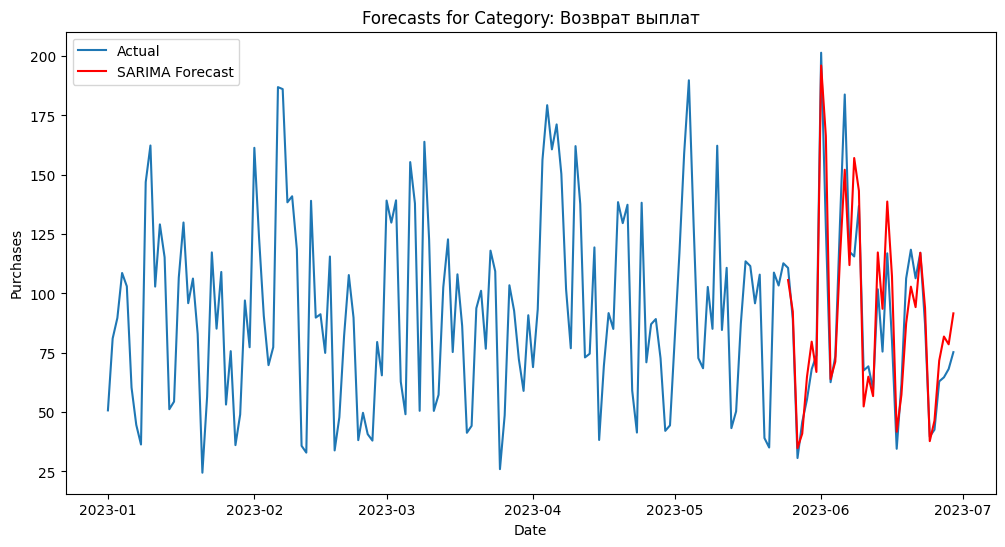

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(category_data['input_'], label='Actual')
plt.plot(np.exp((sarima_mean_1+sarima_mean_2)/2), label='SARIMA Forecast', color='r')

plt.xlabel('Date')
plt.ylabel('Purchases')
plt.title(f'Forecasts for Category: {category}')
plt.legend()
plt.show()

(132, 24) (34, 24)
0:	learn: 0.4535991	total: 2.62ms	remaining: 2.62s
200:	learn: 0.0344591	total: 4.72s	remaining: 18.8s
400:	learn: 0.0070661	total: 11.5s	remaining: 17.2s
600:	learn: 0.0017736	total: 14.2s	remaining: 9.4s
800:	learn: 0.0005908	total: 16.3s	remaining: 4.04s
999:	learn: 0.0002057	total: 18.4s	remaining: 0us
CatBoost MAPE: 17.308780667184067


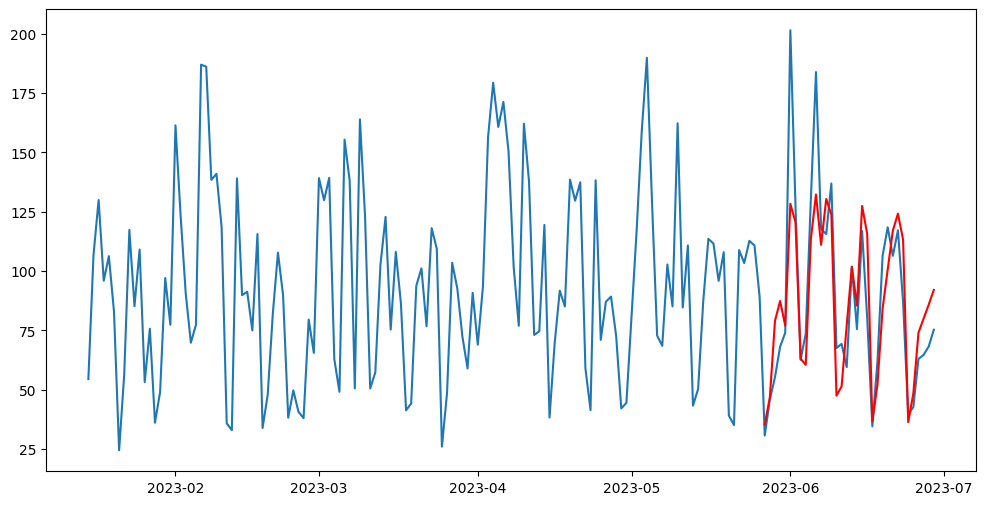

In [ ]:
from catboost import CatBoostRegressor

train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size].drop(columns=['requests', 'stage', 'dt', 'month'])
test_data = df.iloc[train_size:].drop(columns=['requests', 'stage', 'dt', 'month'])

X_train = train_data.drop(columns=['log_input_', 'input_'])
y_train = train_data['log_input_']
X_test = test_data.drop(columns=['log_input_', 'input_'])
y_test = test_data['input_']

print(X_train.shape, X_test.shape)

model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=8,
                          l2_leaf_reg=3.0, loss_function='RMSE',
                          random_seed=42, early_stopping_rounds=50, verbose=200)
model.fit(X_train, y_train, cat_features=['is_weekend', 'dow', 'dom', 'is_holiday'])

preds = pd.DataFrame(model.predict(X_test))
preds.index = y_test.index

mape_catboost = MAPE(y_test, np.exp(preds[0]))

print(f'CatBoost MAPE: {mape_catboost}')


plt.figure(figsize=(12, 6))
plt.plot(df['input_'], label='Actual')
plt.plot(np.exp(preds), label='CatBoost Forecast', color='r');

In [ ]:
from sklearn.model_selection import GridSearchCV

def create_lag_features(df, lags=7, window=7):
    for lag in range(7, lags + 1):
        df[f'lag_{lag}'] = df['log_input_'].shift(lag)
    df['rolling_mean'] = df['log_input_'].shift(1).rolling(window=window).mean()
    df['rolling_max'] = df['log_input_'].shift(1).rolling(window=window).max()
    df['rolling_min'] = df['log_input_'].shift(1).rolling(window=window).min()
    df['rolling_std'] = df['log_input_'].shift(1).rolling(window=window).std()
    return df

# Применение функций
df = create_lag_features(df, lags=14, window=7)
df.dropna(inplace=True)

param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5]
}

# Инициализация модели
catboost_model = CatBoostRegressor(loss_function='MAPE', random_seed=42)

# Поиск по сетке
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Обучение модели с лучшими параметрами
best_model = CatBoostRegressor(**best_params, loss_function='MAPE', random_seed=42, verbose=200)
best_model.fit(X_train, y_train, cat_features=['is_weekend', 'dow', 'dom', 'is_holiday'])

preds = pd.DataFrame(best_model.predict(X_test))
preds.index = y_test.index

mape_catboost = MAPE(y_test, np.exp(preds[0]))

print(f'CatBoost MAPE: {mape_catboost}')


plt.figure(figsize=(12, 6))
plt.plot(df['input_'], label='Actual')
plt.plot(np.exp(preds), label='CatBoost Forecast', color='r');

ensemble MAPE: 14.062476909134173


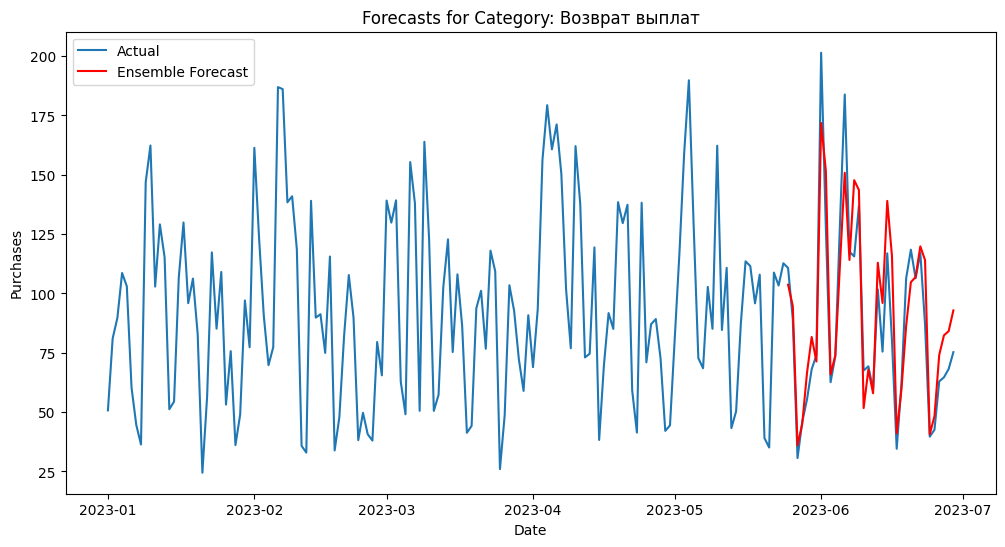

In [ ]:
mse_sarima = MAPE(test_data['input_'], (np.exp(sarima_mean)+np.exp(preds[0]))/2)

print(f'ensemble MAPE: {mse_sarima}')


    # Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(category_data['input_'], label='Actual')
plt.plot((np.exp(sarima_mean)+np.exp(preds[0]))/2, label='Ensemble Forecast', color='r')

plt.xlabel('Date')
plt.ylabel('Purchases')
plt.title(f'Forecasts for Category: {category}')
plt.legend()
plt.show()

0:	learn: 0.4537211	total: 10.8ms	remaining: 10.8s
200:	learn: 0.0667995	total: 403ms	remaining: 1.6s
400:	learn: 0.0293855	total: 946ms	remaining: 1.41s
600:	learn: 0.0141009	total: 1.49s	remaining: 992ms
800:	learn: 0.0075090	total: 1.98s	remaining: 491ms
999:	learn: 0.0040895	total: 2.4s	remaining: 0us
ensemble MAPE: 0.1258431926186517


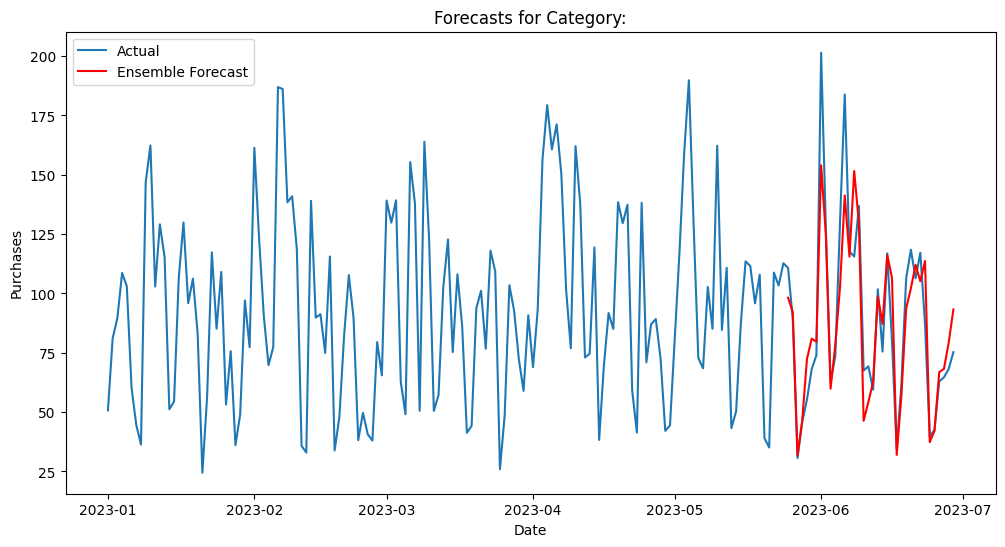

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size].drop(columns=['stage', 'month'])
test_data = df.iloc[train_size:].drop(columns=['stage', 'month'])

X_train = train_data.drop(columns=['log_input_', 'input_'])
y_train = train_data['log_input_']
X_test = test_data.drop(columns=['log_input_', 'input_'])
y_test = test_data['input_']


# Определение базовых моделей
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=8, l2_leaf_reg=3.0,
                              loss_function='RMSE', random_seed=42,
                              early_stopping_rounds=50, verbose=200)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=8, random_state=42)

X_train = X_train[['is_weekend', 'dow', 'dom', 'is_holiday', 'seasonly', 'seasonly1']]
X_test = X_test[['is_weekend', 'dow', 'dom', 'is_holiday', 'seasonly', 'seasonly1']]
# Обучение базовых моделей
cat_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Предсказания базовых моделей
cat_preds_train = cat_model.predict(X_train)
rf_preds_train = rf_model.predict(X_train)
xgb_preds_train = xgb_model.predict(X_train)

cat_preds_test = cat_model.predict(X_test)
rf_preds_test = rf_model.predict(X_test)
xgb_preds_test = xgb_model.predict(X_test)

# Создание мета-признаков
X_train_meta = np.column_stack((cat_preds_train, rf_preds_train, xgb_preds_train))
X_test_meta = np.column_stack((cat_preds_test, rf_preds_test, xgb_preds_test))


# Параметры для поиска
# xgb_param_grid = {
#     'n_estimators': [500, 1000, 1500],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 9],
#     'subsample': [0.7, 0.9, 1.0]
# }

# # Поиск по сетке для XGBRegressor
# xgb_grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid=xgb_param_grid, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')
# xgb_grid_search.fit(X_train_meta, y_train)

# # Лучшие параметры и оценка
# best_xgb = xgb_grid_search.best_estimator_
# print(f'Best XGB Parameters: {xgb_grid_search.best_params_}')

# final_preds = best_xgb.predict(X_test_meta)

# Предсказания и оценка мета-модели XGB
meta_model = Lasso(alpha=0.01)

meta_model.fit(X_train_meta, y_train)

# Финальное предсказание
final_preds = meta_model.predict(X_test_meta)


mse_sarima = mean_absolute_percentage_error(test_data['input_'], np.exp(final_preds))

print(f'ensemble MAPE: {mse_sarima}')
    # Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(df['input_'], label='Actual')
plt.plot(X_test.index, np.exp(final_preds), label='Ensemble Forecast', color='r')

plt.xlabel('Date')
plt.ylabel('Purchases')
plt.title(f'Forecasts for Category:')
plt.legend()
plt.show()